In [ ]:
# Imports and Setup
import os
import sys
sys.path.append('..')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Enable Metal GPU acceleration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Metal GPU detected: {physical_devices}")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        pass
else:
    print("No GPU detected - using CPU")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
CONFIG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,  # Optimized for M3
    'EPOCHS_PHASE1': 25,
    'EPOCHS_PHASE2': 10,
    'LEARNING_RATE_PHASE1': 1e-3,
    'LEARNING_RATE_PHASE2': 1e-5,
    'NUM_CLASSES': 38,
    'DATA_DIR': '../data',
    'MODEL_DIR': '../models',
    'VIZ_DIR': '../visualizations'
}

# Create directories
os.makedirs(CONFIG['MODEL_DIR'], exist_ok=True)
os.makedirs(os.path.join(CONFIG['MODEL_DIR'], 'checkpoints'), exist_ok=True)
os.makedirs(CONFIG['VIZ_DIR'], exist_ok=True)

print("Configuration loaded successfully!")
print(json.dumps(CONFIG, indent=2))

Metal GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configuration loaded successfully!
{
  "IMG_SIZE": 224,
  "BATCH_SIZE": 32,
  "EPOCHS_PHASE1": 25,
  "EPOCHS_PHASE2": 10,
  "LEARNING_RATE_PHASE1": 0.001,
  "LEARNING_RATE_PHASE2": 1e-05,
  "NUM_CLASSES": 38,
  "DATA_DIR": "../data",
  "MODEL_DIR": "../models",
  "VIZ_DIR": "../visualizations"
}


In [ ]:
# Data Augmentation and Loading
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    validation_split=0.15
)

# Training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(CONFIG['DATA_DIR'], 'train'),
    target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data
validation_generator = val_datagen.flow_from_directory(
    os.path.join(CONFIG['DATA_DIR'], 'train'),
    target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Store class names
class_names = list(train_generator.class_indices.keys())
CONFIG['NUM_CLASSES'] = len(class_names)

# Save class names
with open(os.path.join(CONFIG['MODEL_DIR'], 'class_names.json'), 'w') as f:
    json.dump(class_names, f, indent=2)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names[:5]}... (showing first 5)")

Found 59766 images belonging to 38 classes.
Found 10529 images belonging to 38 classes.
Training samples: 59766
Validation samples: 10529
Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']... (showing first 5)


In [ ]:
# Build EfficientNetB0 Model
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes, img_size=224, trainable_base=False):
    """
    Build EfficientNetB0 transfer learning model
    
    Args:
        num_classes: Number of output classes
        img_size: Input image size
        trainable_base: Whether to train base model layers
        
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Preprocessing for EfficientNet
    x = keras.applications.efficientnet.preprocess_input(inputs)
    
    # Load EfficientNetB0 with ImageNet weights
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=x,
        pooling=None
    )
    base_model.trainable = trainable_base
    
    # Custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Dense(512, activation='relu', name='dense_512')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)
    x = layers.Dense(256, activation='relu', name='dense_256')(x)
    x = layers.Dropout(0.2, name='dropout_2')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model
    model = keras.Model(inputs, outputs, name='EfficientNetB0_PlantDisease')
    
    return model, base_model

# Build initial model (frozen base)
model, base_model = build_model(CONFIG['NUM_CLASSES'], CONFIG['IMG_SIZE'], trainable_base=False)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE_PHASE1']),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("Model built successfully!")
# model.summary()
print(f"\nTrainable parameters: {model.count_params():,}")

Model built successfully!

Trainable parameters: 4,851,657


In [ ]:
# Training Callbacks
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,
    CSVLogger, TensorBoard, LambdaCallback
)

# Checkpoint directory
checkpoint_dir = os.path.join(CONFIG['MODEL_DIR'], 'checkpoints')

# Define callbacks
callbacks_phase1 = [
    # Save best model
    ModelCheckpoint(
        os.path.join(CONFIG['MODEL_DIR'], 'best_model_phase1.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # CSV logger
    CSVLogger(
        os.path.join(CONFIG['MODEL_DIR'], 'training_phase1.csv'),
        separator=',',
        append=False
    ),
    
    # TensorBoard
    TensorBoard(
        log_dir=os.path.join(CONFIG['MODEL_DIR'], 'logs', 'phase1'),
        histogram_freq=1,
        write_graph=True
    ),
    
    # Periodic checkpoints
    ModelCheckpoint(
        os.path.join(checkpoint_dir, 'checkpoint_epoch_{epoch:02d}.keras'),
        save_freq='epoch',
        verbose=0
    )
]

print("Callbacks configured successfully!")

Callbacks configured successfully!


In [6]:
# Cell 5: Phase 1 Training (Frozen Base)
print("="*70)
print("PHASE 1: Training with Frozen Base Model")
print("="*70)

history_phase1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=CONFIG['EPOCHS_PHASE1'],
    callbacks=callbacks_phase1,
    verbose=1
)

print("\nPhase 1 training complete!")
print(f"Best validation accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

PHASE 1: Training with Frozen Base Model
Epoch 1/25


2025-11-23 12:16:20.662144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1868/1868 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7219 - auc: 0.9372 - loss: 1.5015 - precision: 0.7553 - recall: 0.7075
Epoch 1: val_accuracy improved from None to 0.88527, saving model to ../models/best_model_phase1.keras
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 317s 167ms/step - accuracy: 0.7935 - auc: 0.9494 - loss: 1.3565 - precision: 0.8075 - recall: 0.7878 - val_accuracy: 0.8853 - val_auc: 0.9692 - val_loss: 0.9070 - val_precision: 0.8875 - val_recall: 0.8847 - learning_rate: 0.0010
Epoch 2/25
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8350 - auc: 0.9437 - loss: 1.8621 - precision: 0.8368 - recall: 0.8344
Epoch 2: val_accuracy did not improve from 0.88527
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 313s 168ms/step - accuracy: 0.8384 - auc: 0.9415 - loss: 2.1330 - precision: 0.8397 - recall: 0.8379 - val_accuracy: 0.8846 - val_auc: 0.9544 - val_loss: 2.0349 - val_precision: 0.8852 - val_recall: 0.8845 - learning_rate: 0.0010
Epoch 3/25
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/st

In [ ]:
# Phase 2 - Fine-tuning
print("="*70)
print("PHASE 2: Fine-tuning (Unfreezing Last Layers)")
print("="*70)

# Unfreeze base model for fine-tuning
base_model.trainable = True

# Freeze early layers (keep first 80% frozen)
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.8)

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

print(f"Unfrozen {total_layers - freeze_until} layers out of {total_layers}")

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE_PHASE2']),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# New callbacks for phase 2
callbacks_phase2 = [
    ModelCheckpoint(
        os.path.join(CONFIG['MODEL_DIR'], 'final', 'plant_disease_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-8,
        verbose=1
    ),
    
    CSVLogger(
        os.path.join(CONFIG['MODEL_DIR'], 'training_phase2.csv'),
        separator=',',
        append=False
    ),
    
    TensorBoard(
        log_dir=os.path.join(CONFIG['MODEL_DIR'], 'logs', 'phase2'),
        histogram_freq=1
    )
]

# Create final model directory
os.makedirs(os.path.join(CONFIG['MODEL_DIR'], 'final'), exist_ok=True)

# Continue training (fine-tuning)
history_phase2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=CONFIG['EPOCHS_PHASE2'],
    callbacks=callbacks_phase2,
    verbose=1
)

print("\nPhase 2 training complete!")
print(f"Final validation accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

# Save training history
history_combined = {
    'phase1': history_phase1.history,
    'phase2': history_phase2.history
}

with open(os.path.join(CONFIG['MODEL_DIR'], 'training_history.json'), 'w') as f:
    json.dump(history_combined, f, indent=2, default=float)

print("\nTraining history saved!")

PHASE 2: Fine-tuning (Unfreezing Last Layers)
Unfrozen 48 layers out of 238
Epoch 1/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7795 - auc: 0.9334 - loss: 1.9045 - precision: 0.7836 - recall: 0.7779
Epoch 1: val_accuracy improved from None to 0.91414, saving model to ../models/final/plant_disease_model.keras
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 429s 224ms/step - accuracy: 0.8125 - auc: 0.9455 - loss: 1.5382 - precision: 0.8162 - recall: 0.8111 - val_accuracy: 0.9141 - val_auc: 0.9784 - val_loss: 0.6307 - val_precision: 0.9157 - val_recall: 0.9136 - learning_rate: 1.0000e-05
Epoch 2/10
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8603 - auc: 0.9631 - loss: 1.0247 - precision: 0.8627 - recall: 0.8589
Epoch 2: val_accuracy improved from 0.91414 to 0.93048, saving model to ../models/final/plant_disease_model.keras
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 406s 217ms/step - accuracy: 0.8664 - auc: 0.9646 - loss: 0.9887 - precision: 0.8686 - recall: 0.8652 - val_accuracy: 0.93

In [ ]:
# Save Final Model in Multiple Formats
print("Saving model in multiple formats...")

# 1. Export in SavedModel format for deployment (Use export() for Keras 3)
model.export(os.path.join(CONFIG['MODEL_DIR'], 'final', 'saved_model'))

# 2. Save model architecture as JSON
model_json = model.to_json()
with open(os.path.join(CONFIG['MODEL_DIR'], 'final', 'model_architecture.json'), 'w') as f:
    json.dump(json.loads(model_json), f, indent=2)

# 3. Save model weights separately (Use .weights.h5 for Keras 3)
model.save_weights(os.path.join(CONFIG['MODEL_DIR'], 'final', 'model_weights.weights.h5'))

# 4. Save configuration
with open(os.path.join(CONFIG['MODEL_DIR'], 'final', 'config.json'), 'w') as f:
    json.dump(CONFIG, f, indent=2)
print("All model formats saved successfully!")
print(f"Model directory: {CONFIG['MODEL_DIR']}/final/")

Saving model in multiple formats...
INFO:tensorflow:Assets written to: ../models/final/saved_model/assets


INFO:tensorflow:Assets written to: ../models/final/saved_model/assets


Saved artifact at '../models/final/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_245')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  14462768272: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  14462769040: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  14629481424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629481232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629481808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629482768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629483344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629482192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629482000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629483152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14629483728: TensorS

In [ ]:
# Model Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

print("Evaluating model on validation set...")

# Get predictions
y_true = validation_generator.classes
y_pred_proba = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# Macro metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

# Per-class metrics
per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print results
print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)
print(f"Accuracy:           {accuracy:.4f}")
print(f"\nWeighted Metrics:")
print(f"  Precision:        {precision:.4f}")
print(f"  Recall:           {recall:.4f}")
print(f"  F1-Score:         {f1:.4f}")
print(f"\nMacro Metrics:")
print(f"  Precision:        {precision_macro:.4f}")
print(f"  Recall:           {recall_macro:.4f}")
print(f"  F1-Score:         {f1_macro:.4f}")

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Save metrics
metrics = {
    'accuracy': float(accuracy),
    'weighted': {
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    },
    'macro': {
        'precision': float(precision_macro),
        'recall': float(recall_macro),
        'f1': float(f1_macro)
    },
    'per_class': {
        class_names[i]: {
            'precision': float(per_class_precision[i]),
            'recall': float(per_class_recall[i]),
            'f1': float(per_class_f1[i]),
            'support': int(per_class_support[i])
        } for i in range(len(class_names))
    }
}

with open(os.path.join(CONFIG['MODEL_DIR'], 'final', 'evaluation_metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=2)

print("\nMetrics saved to evaluation_metrics.json")

Evaluating model on validation set...
330/330 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step

EVALUATION METRICS
Accuracy:           0.9662

Weighted Metrics:
  Precision:        0.9679
  Recall:           0.9662
  F1-Score:         0.9665

Macro Metrics:
  Precision:        0.9677
  Recall:           0.9659
  F1-Score:         0.9662

CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9897    0.9570    0.9731       302
                                 Apple___Black_rot     0.9868    1.0000    0.9933       298
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000       264
                                   Apple___healthy     0.9769    0.9834    0.9801       301
                               Blueberry___healthy     0.9610    0.9963    0.9783       272
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9841    0.9920       252
      

Generating visualizations...


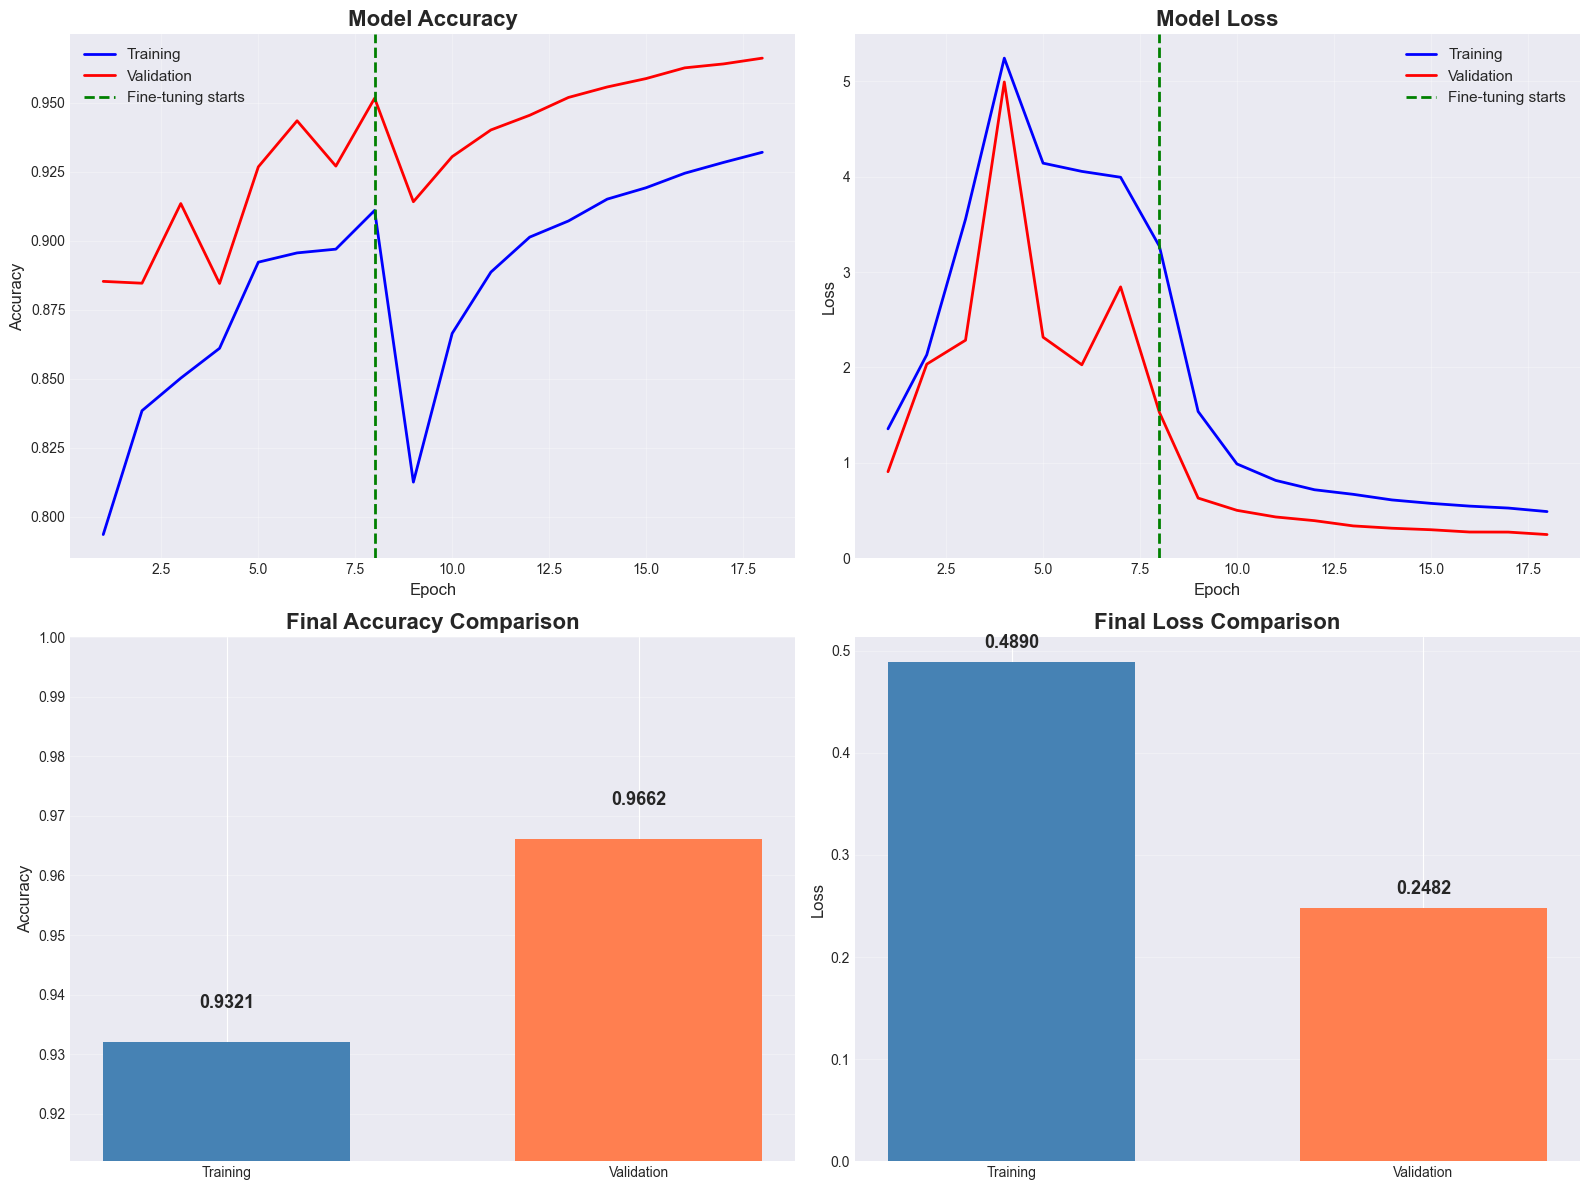

Training history plot saved to ../visualizations/01_training_history.png


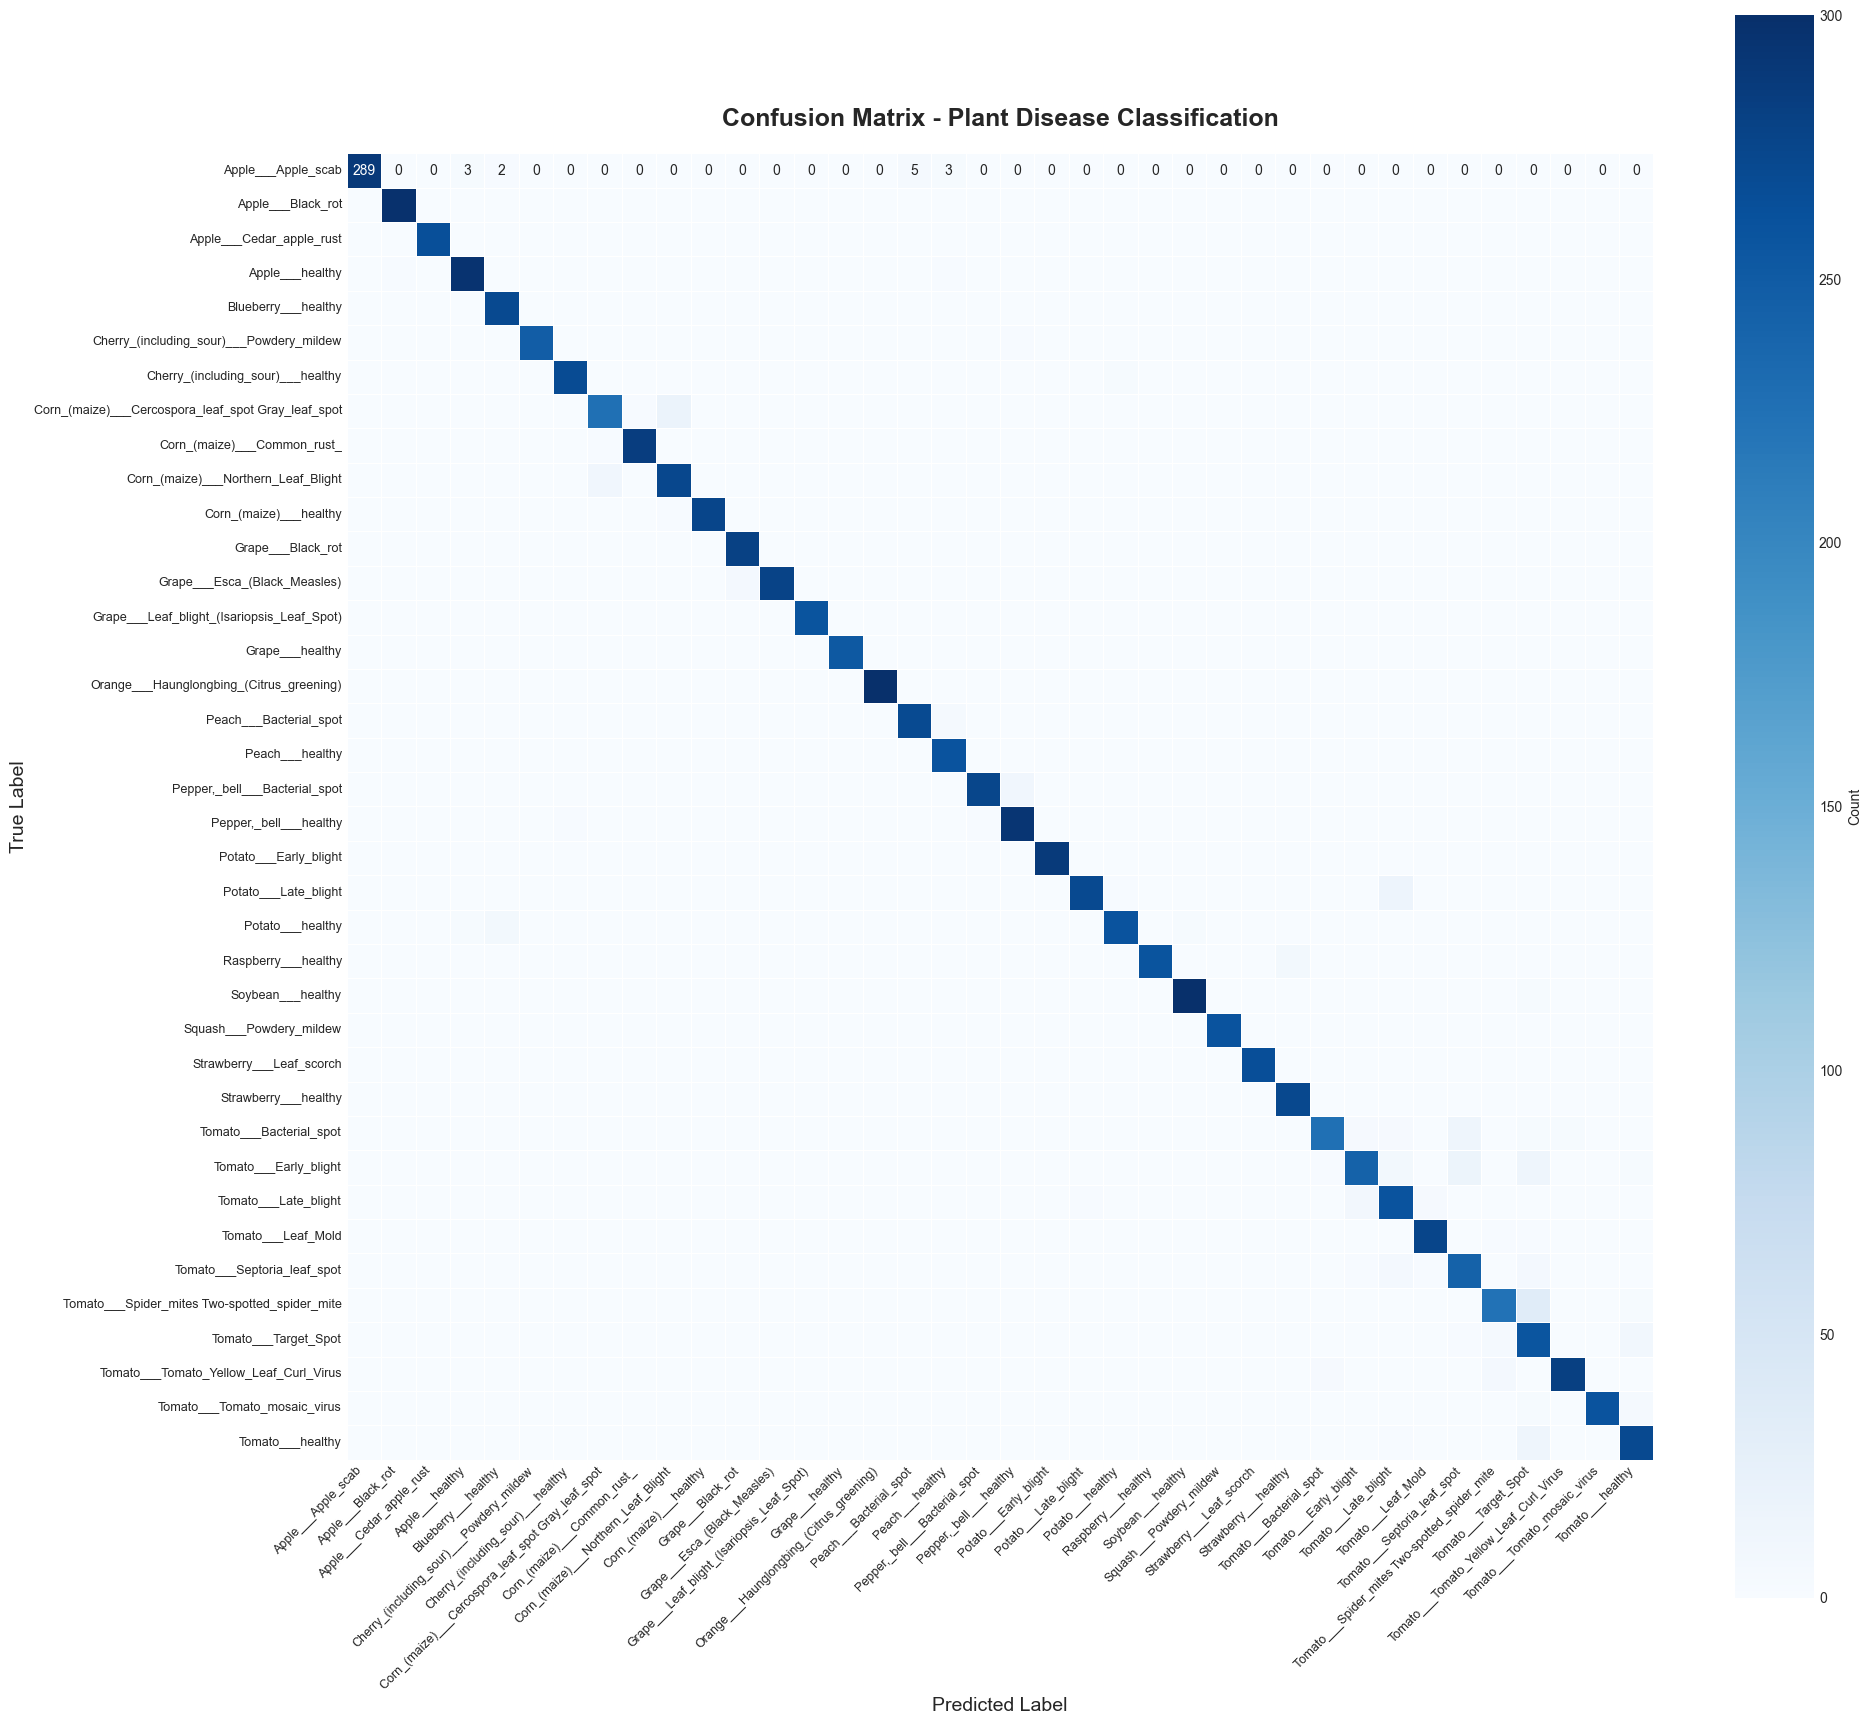

Confusion matrix saved to ../visualizations/02_confusion_matrix.png


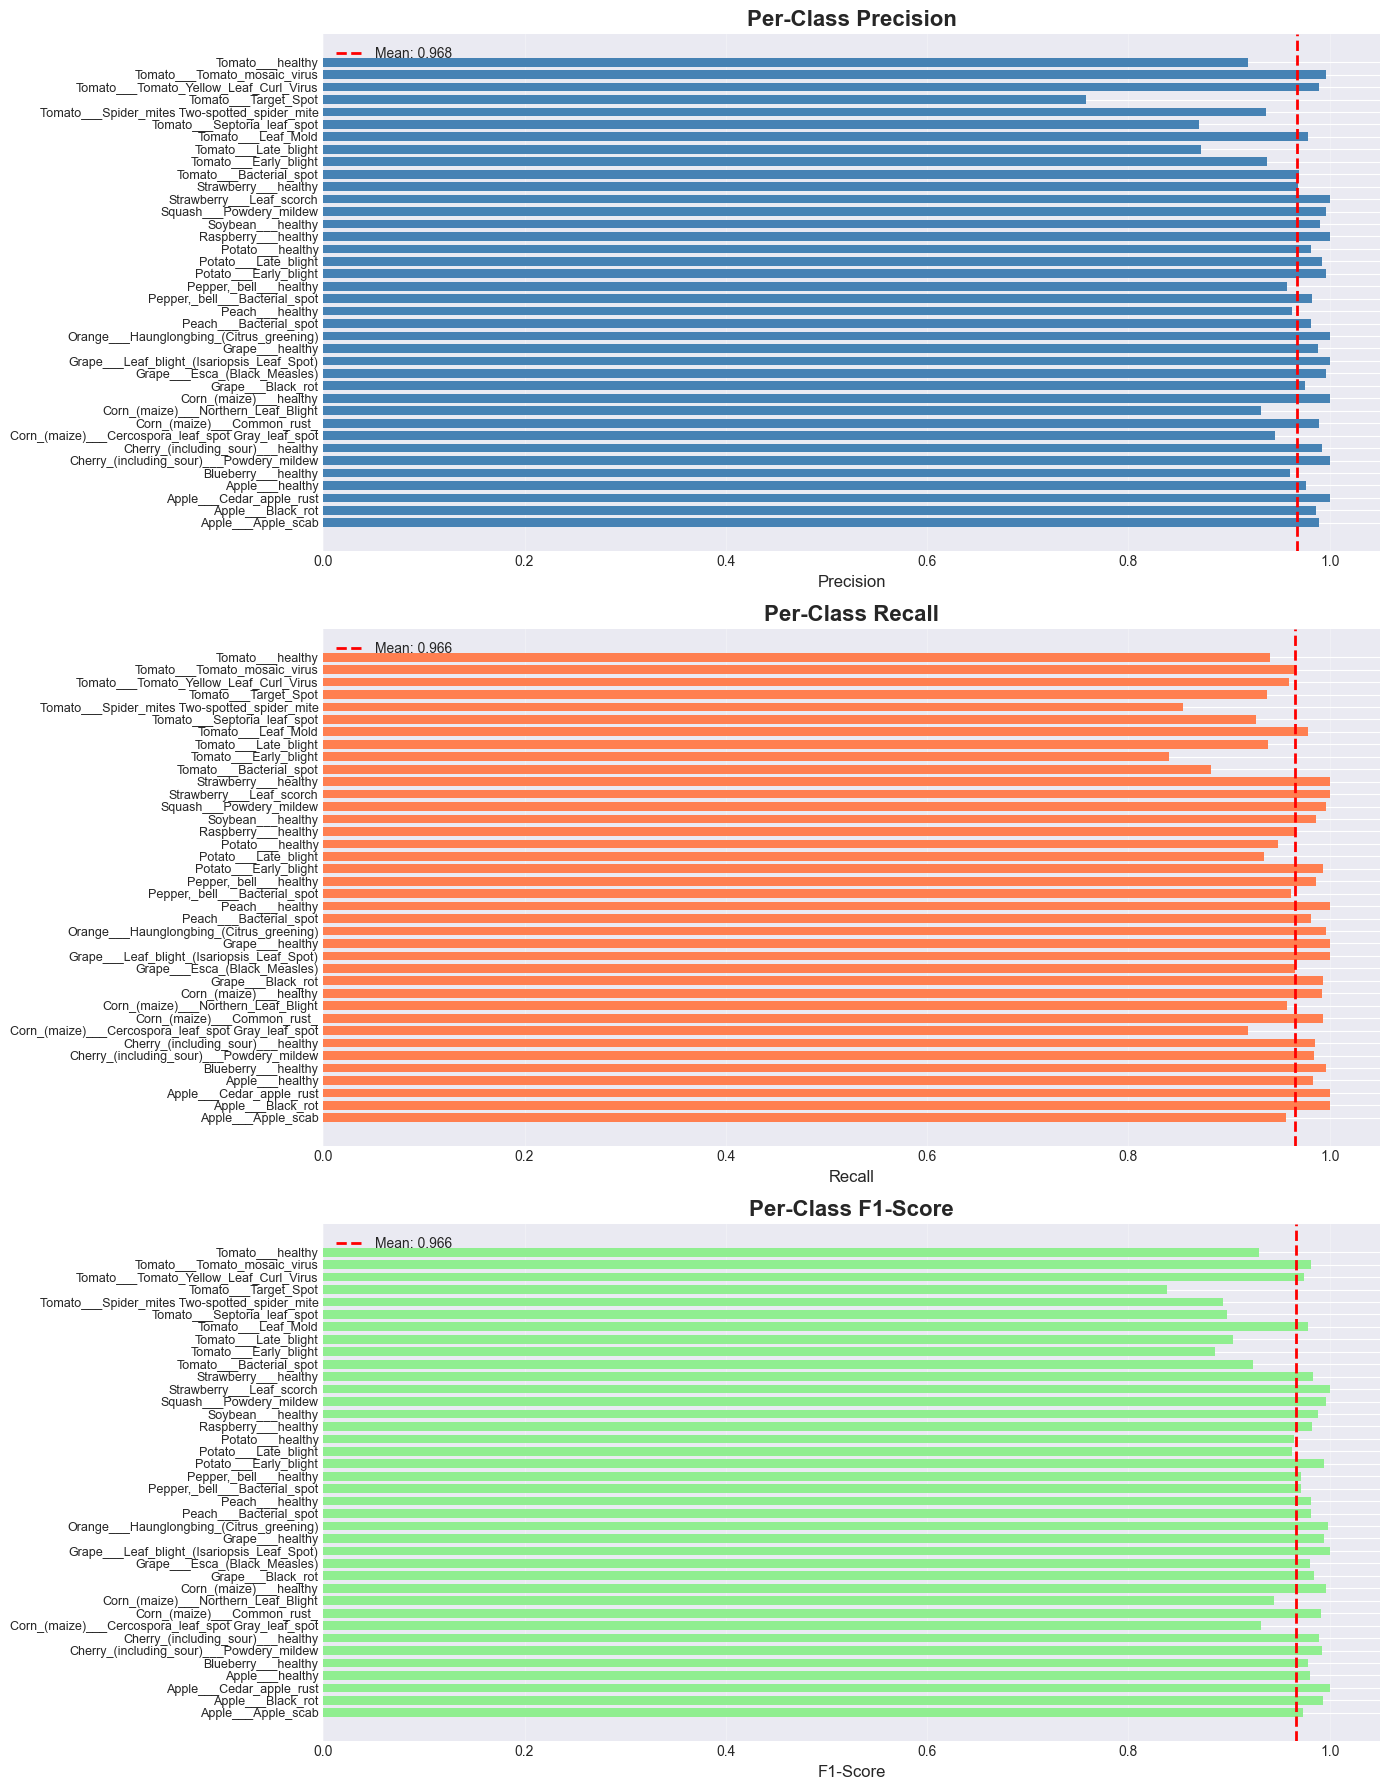

Per-class metrics saved to ../visualizations/03_per_class_metrics.png


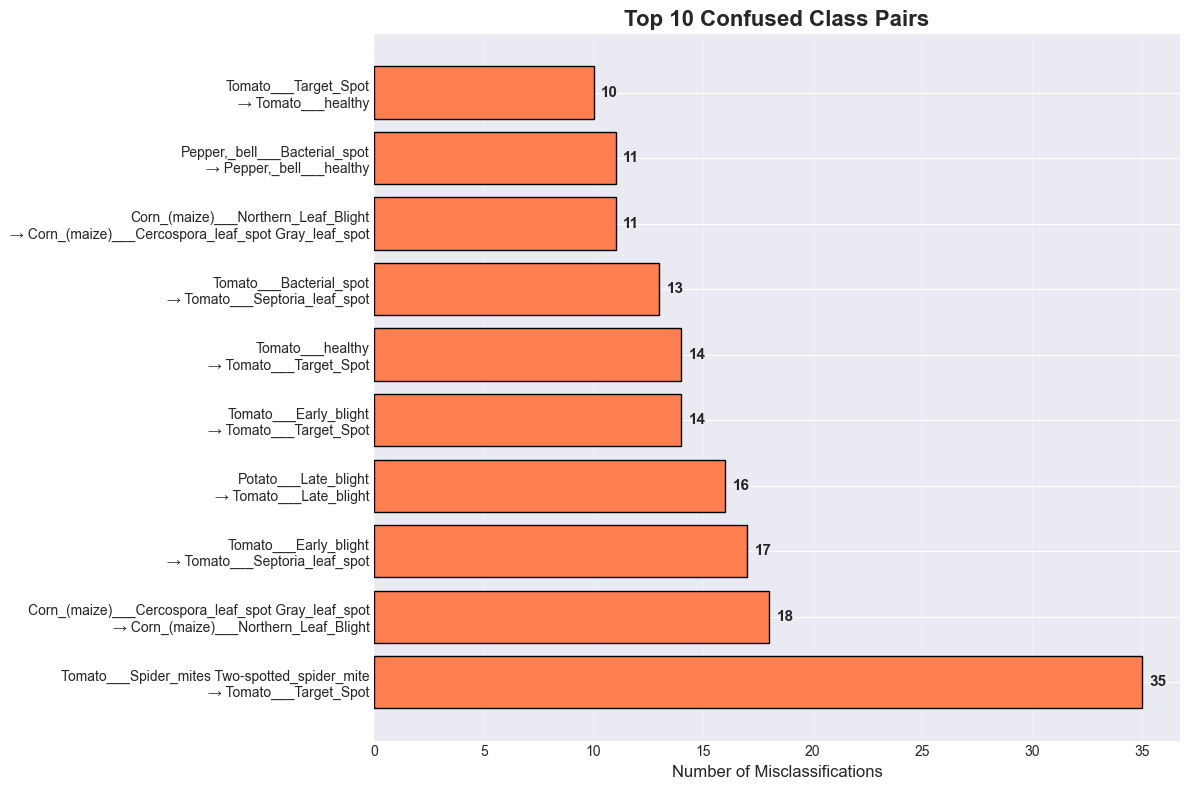

Top confusions saved to ../visualizations/04_top_confusions.png

All visualizations generated successfully!


In [ ]:
# Visualization Functions
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def plot_training_history(history_p1, history_p2, save_path):
    """Plot training and validation metrics"""
    
    # Combine histories
    acc = history_p1['accuracy'] + history_p2['accuracy']
    val_acc = history_p1['val_accuracy'] + history_p2['val_accuracy']
    loss = history_p1['loss'] + history_p2['loss']
    val_loss = history_p1['val_loss'] + history_p2['val_loss']
    
    epochs = range(1, len(acc) + 1)
    phase1_end = len(history_p1['accuracy'])
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy plot
    axes[0, 0].plot(epochs, acc, 'b-', linewidth=2, label='Training')
    axes[0, 0].plot(epochs, val_acc, 'r-', linewidth=2, label='Validation')
    axes[0, 0].axvline(x=phase1_end, color='g', linestyle='--', linewidth=2, label='Fine-tuning starts')
    axes[0, 0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[0, 1].plot(epochs, loss, 'b-', linewidth=2, label='Training')
    axes[0, 1].plot(epochs, val_loss, 'r-', linewidth=2, label='Validation')
    axes[0, 1].axvline(x=phase1_end, color='g', linestyle='--', linewidth=2, label='Fine-tuning starts')
    axes[0, 1].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Final accuracy comparison
    final_train = acc[-1]
    final_val = val_acc[-1]
    bars = axes[1, 0].bar(['Training', 'Validation'], [final_train, final_val],
                          color=['steelblue', 'coral'], width=0.6)
    axes[1, 0].set_ylim([min(final_train, final_val) - 0.02, 1.0])
    axes[1, 0].set_title('Final Accuracy Comparison', fontsize=16, fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, [final_train, final_val]):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{val:.4f}', ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    # Final loss comparison
    final_train_loss = loss[-1]
    final_val_loss = val_loss[-1]
    bars = axes[1, 1].bar(['Training', 'Validation'], [final_train_loss, final_val_loss],
                          color=['steelblue', 'coral'], width=0.6)
    axes[1, 1].set_title('Final Loss Comparison', fontsize=16, fontweight='bold')
    axes[1, 1].set_ylabel('Loss', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, [final_train_loss, final_val_loss]):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{val:.4f}', ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Training history plot saved to {save_path}")

def plot_confusion_matrix(cm, class_names, save_path):
    """Plot confusion matrix heatmap"""
    
    plt.figure(figsize=(20, 18))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, linewidths=0.5,
                square=True)
    
    plt.title('Confusion Matrix - Plant Disease Classification', 
              fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Confusion matrix saved to {save_path}")

def plot_per_class_metrics(precision, recall, f1, class_names, save_path):
    """Plot per-class performance metrics"""
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))
    
    x = np.arange(len(class_names))
    width = 0.7
    
    # Precision
    axes[0].barh(x, precision, width, color='steelblue')
    axes[0].set_yticks(x)
    axes[0].set_yticklabels(class_names, fontsize=9)
    axes[0].set_xlabel('Precision', fontsize=12)
    axes[0].set_title('Per-Class Precision', fontsize=16, fontweight='bold')
    axes[0].set_xlim([0, 1.05])
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].axvline(x=precision.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {precision.mean():.3f}')
    axes[0].legend()
    
    # Recall
    axes[1].barh(x, recall, width, color='coral')
    axes[1].set_yticks(x)
    axes[1].set_yticklabels(class_names, fontsize=9)
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_title('Per-Class Recall', fontsize=16, fontweight='bold')
    axes[1].set_xlim([0, 1.05])
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].axvline(x=recall.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {recall.mean():.3f}')
    axes[1].legend()
    
    # F1-Score
    axes[2].barh(x, f1, width, color='lightgreen')
    axes[2].set_yticks(x)
    axes[2].set_yticklabels(class_names, fontsize=9)
    axes[2].set_xlabel('F1-Score', fontsize=12)
    axes[2].set_title('Per-Class F1-Score', fontsize=16, fontweight='bold')
    axes[2].set_xlim([0, 1.05])
    axes[2].grid(True, alpha=0.3, axis='x')
    axes[2].axvline(x=f1.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {f1.mean():.3f}')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Per-class metrics saved to {save_path}")

def plot_top_confusions(cm, class_names, top_n=10, save_path=None):
    """Plot top confused class pairs"""
    
    cm_copy = cm.copy()
    np.fill_diagonal(cm_copy, 0)
    
    # Find top confusions
    confusions = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm_copy[i, j] > 0:
                confusions.append((class_names[i], class_names[j], cm_copy[i, j]))
    
    confusions.sort(key=lambda x: x[2], reverse=True)
    top_confusions = confusions[:top_n]
    
    labels = [f"{true}\n→ {pred}" for true, pred, _ in top_confusions]
    counts = [count for _, _, count in top_confusions]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(labels, counts, color='coral', edgecolor='black')
    plt.xlabel('Number of Misclassifications', fontsize=12)
    plt.title(f'Top {top_n} Confused Class Pairs', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, count) in enumerate(zip(bars, counts)):
        plt.text(count + max(counts)*0.01, i, str(int(count)), 
                va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    if save_path:
        print(f"Top confusions saved to {save_path}")

# Generate all visualizations
print("Generating visualizations...")

# 1. Training history
plot_training_history(
    history_combined['phase1'], 
    history_combined['phase2'],
    os.path.join(CONFIG['VIZ_DIR'], '01_training_history.png')
)

# 2. Confusion matrix
plot_confusion_matrix(
    cm, 
    class_names,
    os.path.join(CONFIG['VIZ_DIR'], '02_confusion_matrix.png')
)

# 3. Per-class metrics
plot_per_class_metrics(
    per_class_precision,
    per_class_recall,
    per_class_f1,
    class_names,
    os.path.join(CONFIG['VIZ_DIR'], '03_per_class_metrics.png')
)

# 4. Top confusions
plot_top_confusions(
    cm,
    class_names,
    top_n=10,
    save_path=os.path.join(CONFIG['VIZ_DIR'], '04_top_confusions.png')
)

print("\nAll visualizations generated successfully!")

Generating GradCAM visualizations...


/Users/cedricizabayo/Developer/ALU/plant-disease-mlops-pipeline/venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_245']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


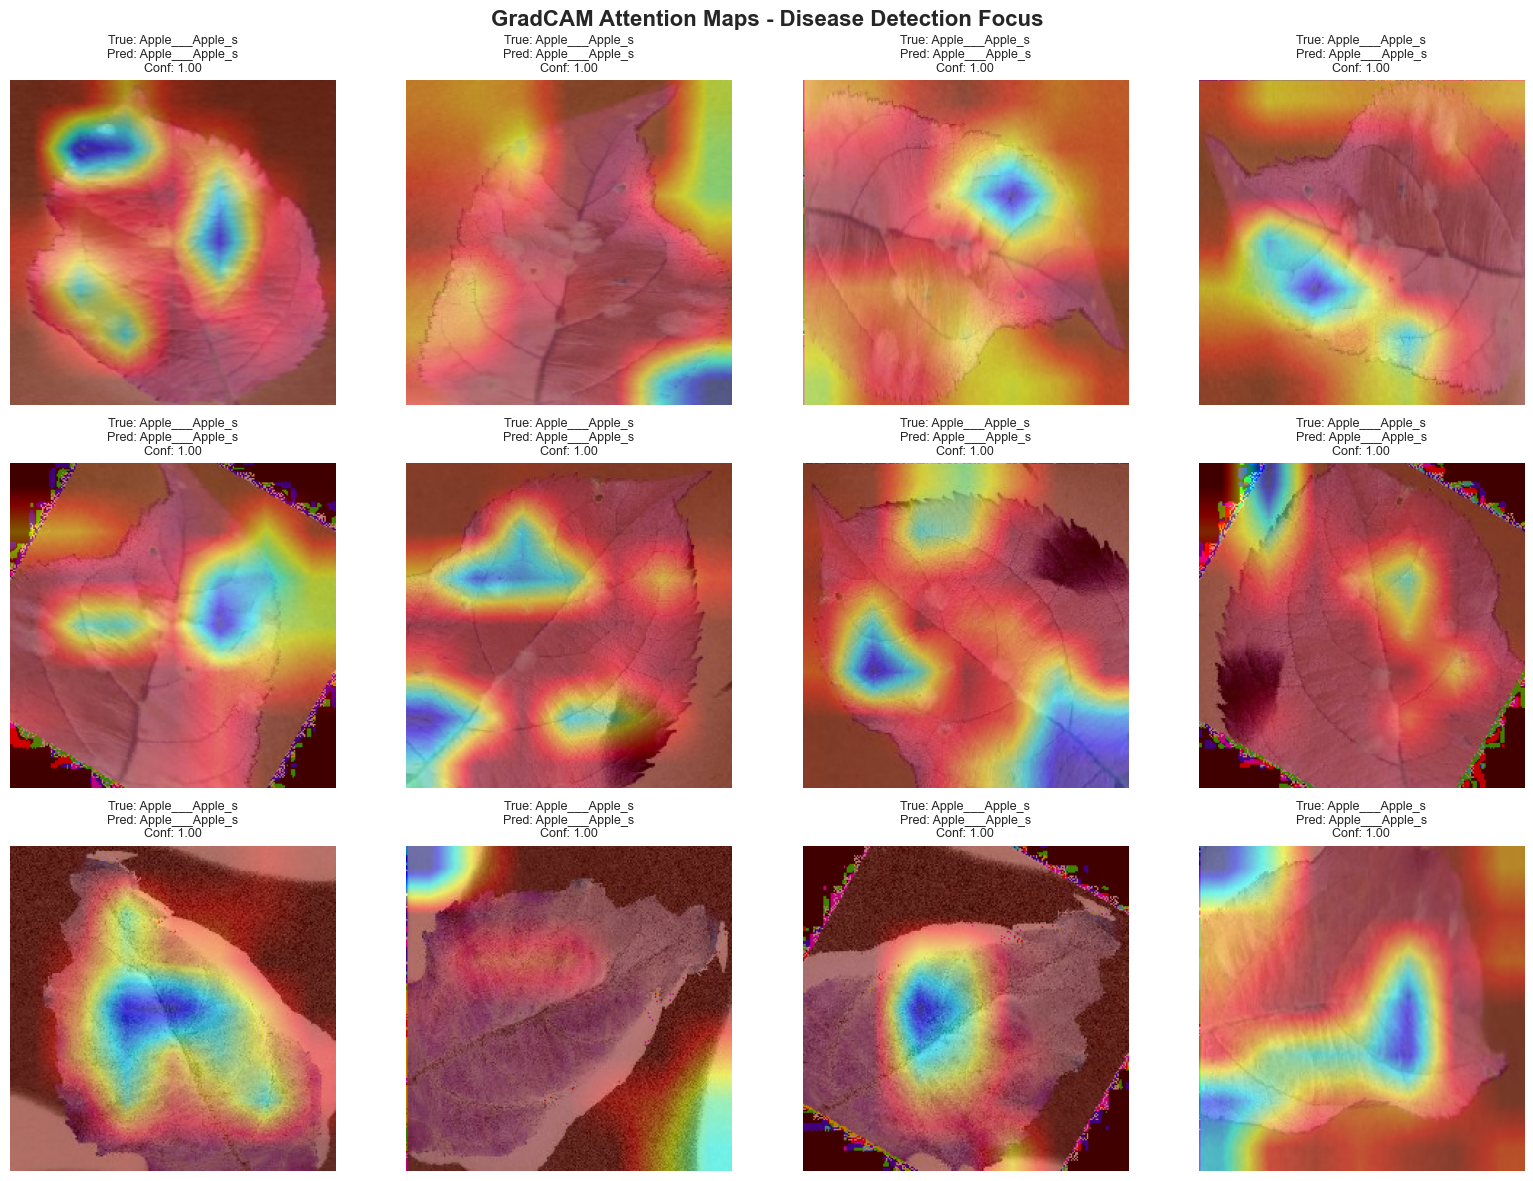

GradCAM visualizations saved!


In [ ]:
# GradCAM Visualization
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate GradCAM heatmap"""
    
    # Create a model that maps input to the activations and output
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Gradient of the output neuron with regard to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel by importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.5):
    """Overlay GradCAM on original image"""
    
    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose
    superimposed = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    
    return superimposed

# Find last conv layer (EfficientNet specific)
last_conv_layer_name = 'top_activation'

# Generate GradCAM for sample images
print("Generating GradCAM visualizations...")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

sample_count = 0
for batch_images, batch_labels in validation_generator:
    if sample_count >= 12:
        break
        
    for i in range(min(batch_images.shape[0], 12 - sample_count)):
        # Get image
        img = batch_images[i]
        true_label = np.argmax(batch_labels[i])
        
        # Predict
        img_expanded = np.expand_dims(img, axis=0)
        preds = model.predict(img_expanded, verbose=0)
        pred_label = np.argmax(preds[0])
        confidence = preds[0][pred_label]
        
        # Generate GradCAM
        heatmap = make_gradcam_heatmap(img_expanded, model, last_conv_layer_name, pred_label)
        
        # Convert image to uint8
        img_uint8 = (img * 255).astype('uint8')
        
        # Overlay
        gradcam_img = overlay_gradcam(img_uint8, heatmap, alpha=0.5)
        
        # Plot
        axes[sample_count].imshow(gradcam_img)
        axes[sample_count].set_title(
            f"True: {class_names[true_label][:15]}\n"
            f"Pred: {class_names[pred_label][:15]}\n"
            f"Conf: {confidence:.2f}",
            fontsize=9
        )
        axes[sample_count].axis('off')
        
        sample_count += 1
        if sample_count >= 12:
            break

plt.suptitle('GradCAM Attention Maps - Disease Detection Focus', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['VIZ_DIR'], '05_gradcam_attention.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("GradCAM visualizations saved!")

# Phase 3: Evaluation & Visualizations
## 1. Plot Training History

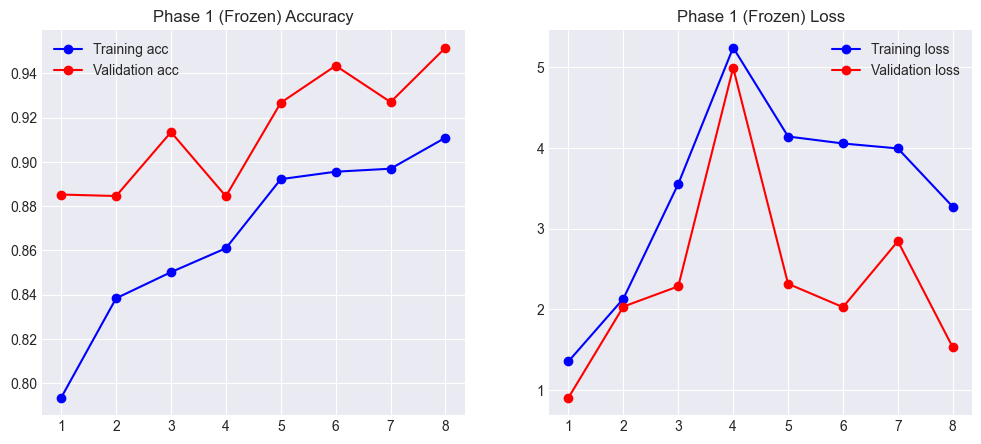

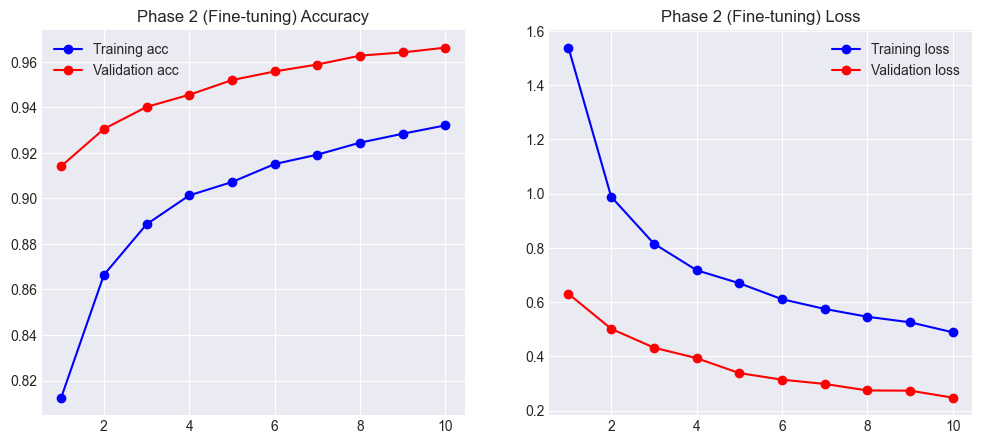

In [13]:
import matplotlib.pyplot as plt

def plot_history(history, phase_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} Loss')
    plt.legend()

    plt.show()

# Plot Phase 1 History
if 'history_phase1' in locals():
    plot_history(history_phase1, 'Phase 1 (Frozen)')

# Plot Phase 2 History
if 'history_phase2' in locals():
    plot_history(history_phase2, 'Phase 2 (Fine-tuning)')

## 2. Evaluation on Validation Set

In [15]:
# Evaluate the final model on the validation set
val_loss, val_acc, val_auc, val_precision, val_recall = model.evaluate(validation_generator)

print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.9662 - auc: 0.9918 - loss: 0.2482 - precision: 0.9668 - recall: 0.9660
Validation Accuracy: 96.62%
Validation Loss: 0.2482
Validation AUC: 0.9668
Validation Precision: 0.9660
Validation Recall: 0.9918


## 3. Confusion Matrix and Classification Report

330/330 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.96      0.97       302
                                 Apple___Black_rot       0.99      1.00      0.99       298
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       264
                                   Apple___healthy       0.98      0.98      0.98       301
                               Blueberry___healthy       0.96      1.00      0.98       272
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       252
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       273
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.92      0.93       246
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       286
            

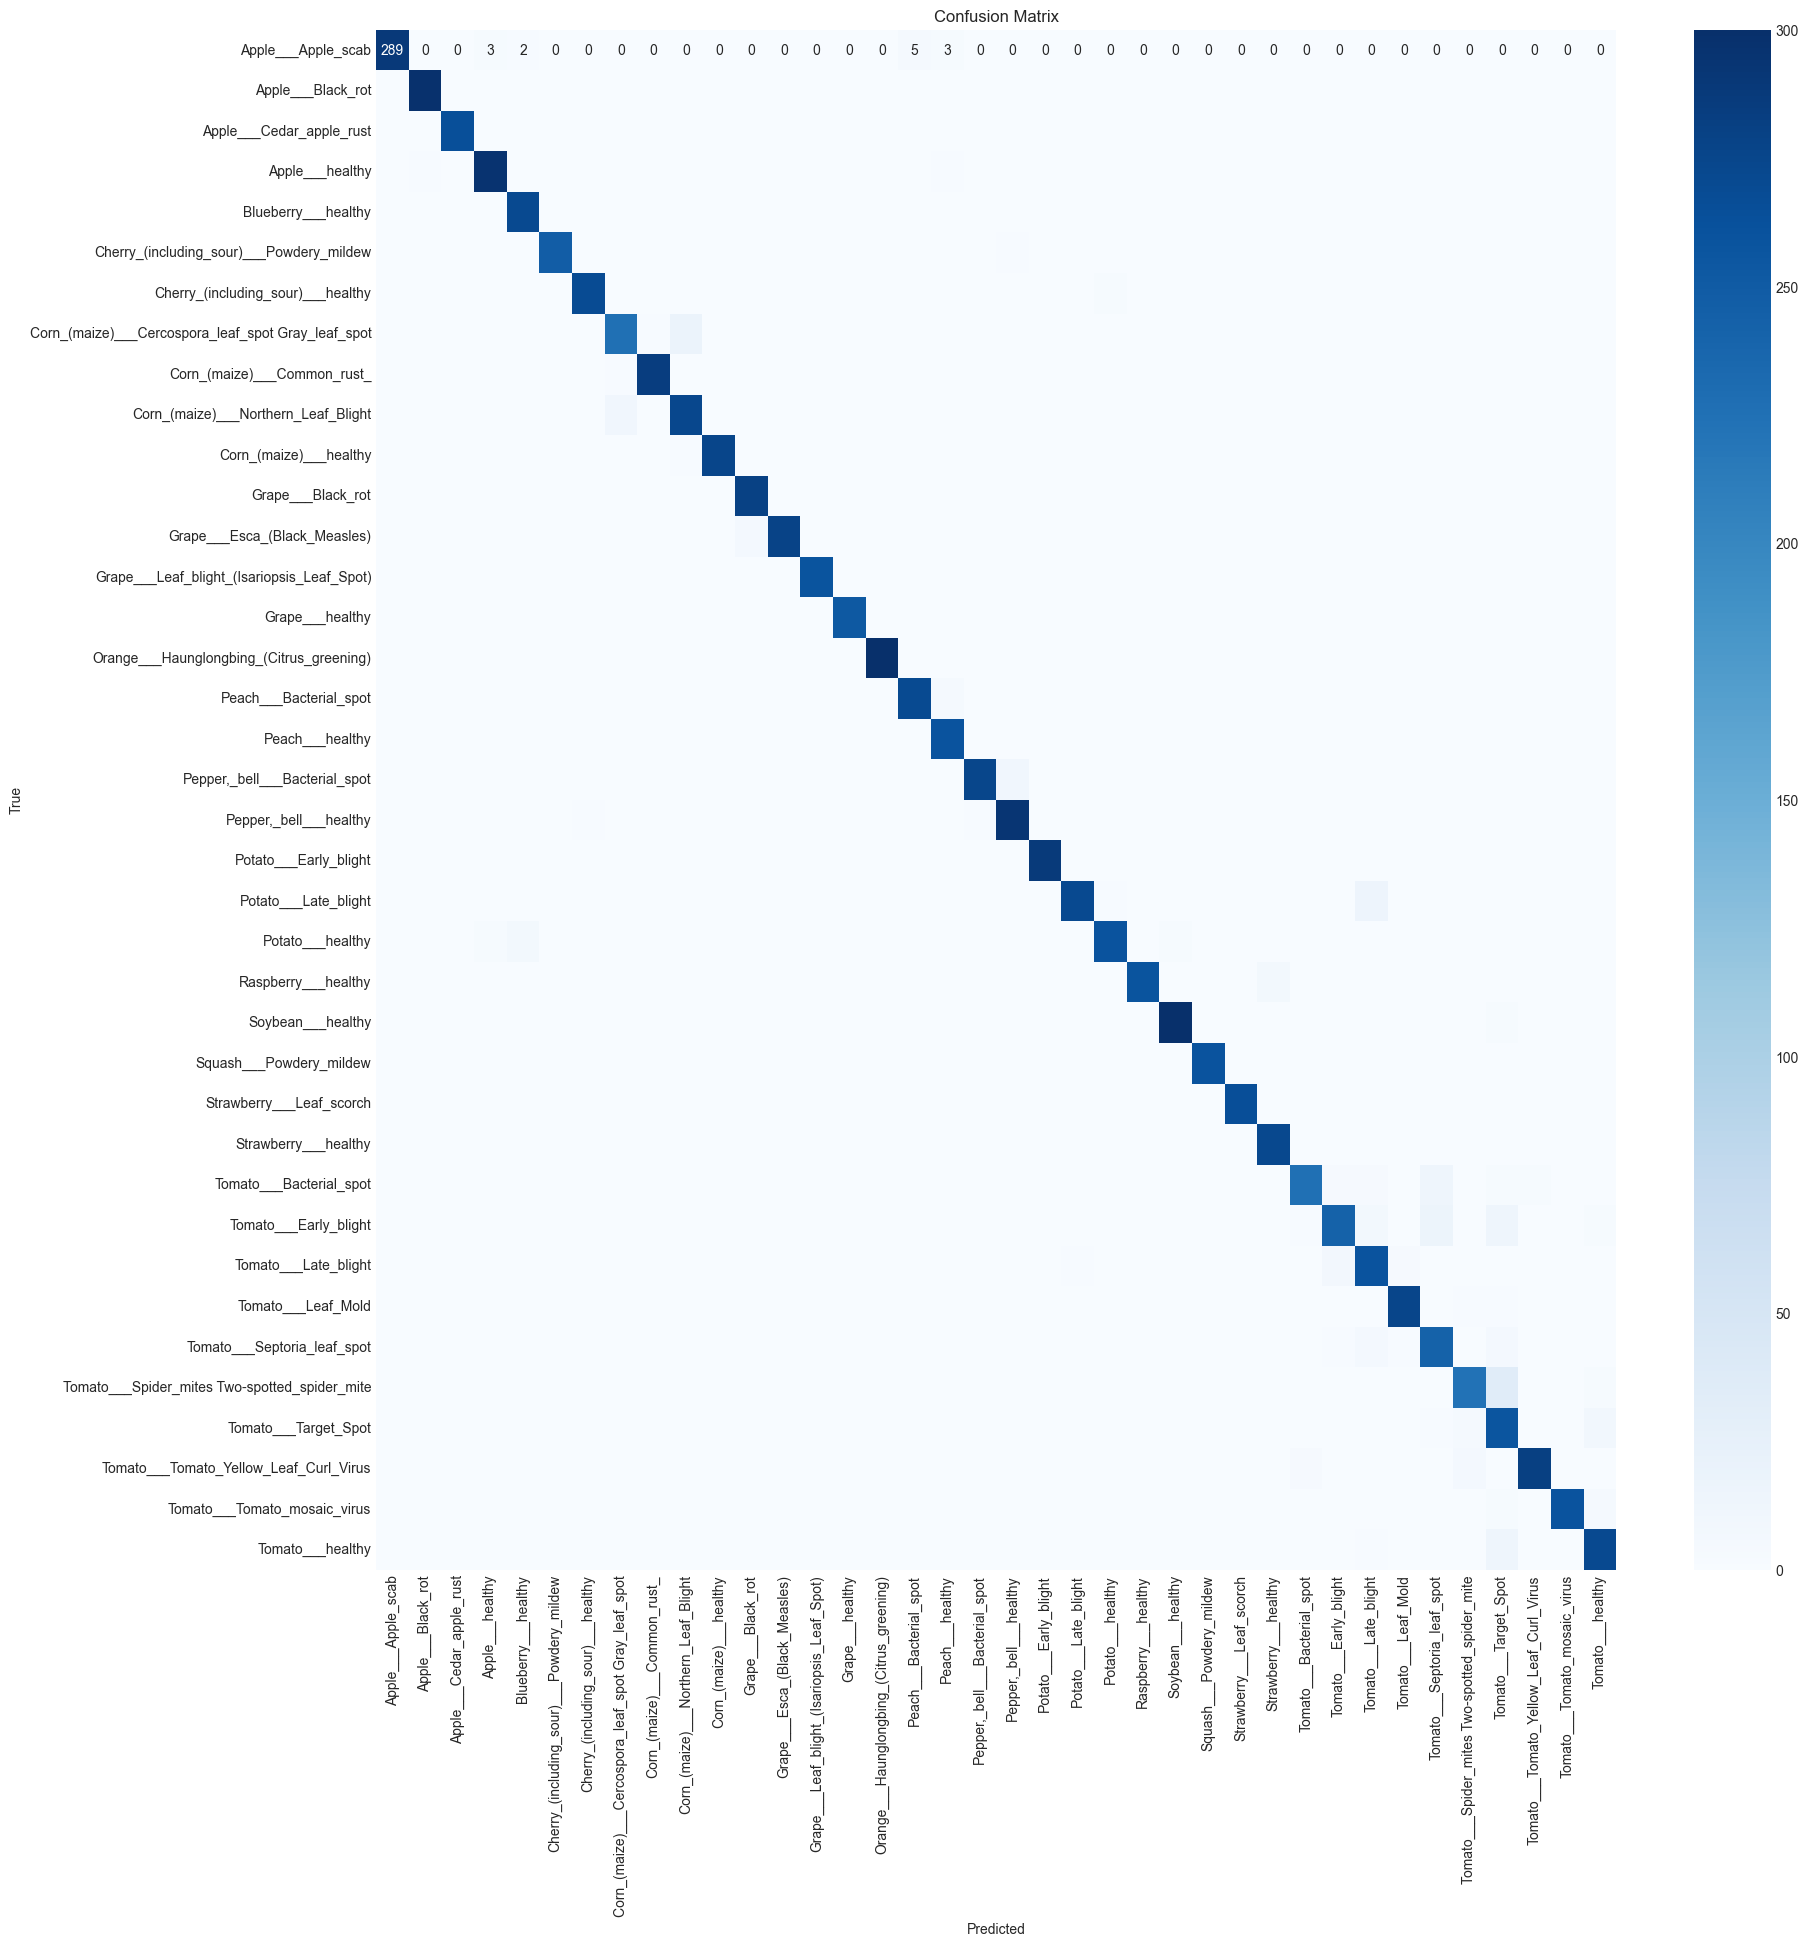

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict on validation set
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = validation_generator.classes

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()